In [69]:
import pandas as pd
import numpy as np
import math
from numpy.random import default_rng

my_rng = default_rng(seed=42) # random number generator

NUM_COHORTS = 16
MAX_DOSE = 1.5  # we want doses from 0 to 1.5 in 0.1 increments

def new_patient(patient_id, day_number):
    return {
            'patient_id': patient_id,
            'cohort': patient_id % NUM_COHORTS,
            'day_number': day_number,
            'infection': my_rng.integers(low=20, high=40, size=1)[0],
            'severity': my_rng.integers(low=10, high=30, size=1)[0],
            'cum_drug' : 0,
            'outcome':'none',
            'efficacy': 0,
            'drug': 0,
           }


def get_infection(yesterday):
    # depends on: infection_prev
    progression = my_rng.integers(low=0, high=10, size=1)[0]
    return yesterday['infection'] + progression


def get_severity(yesterday):
    # depends on: yesterday's severity, infection, & efficacy
    severity_next = yesterday['severity'] * 1.1 + \
                    yesterday['infection'] * 0.1 - \
                    yesterday['efficacy']  # larger coefficient here makes drug work better
    return severity_next
    

def get_cum_drug(yesterday, today):
    # depends on: yesterday's cum_drug_prev, today's drug
    r = 0.6  # larger value responds more slowly to changes in dose
    return yesterday['cum_drug'] * r + today['drug'] * (1 - r)


def get_drug(today):
    # depends on: today's severity
    # This is the function that defines th treatment policy
    # treatment threshold for today
    tx_threshold = 0 # my_rng.integers(low=10, high=20, size=1)[0] 
    if NUM_COHORTS > 1: # dose depends on cohort
      cohort = today['patient_id'] % NUM_COHORTS
      dose = MAX_DOSE * cohort / (NUM_COHORTS - 1)
    else: # random dose
      dose = math.floor(10 * my_rng.uniform( low=0.0, high=MAX_DOSE ))/10  # MAX_DOSE+0.1
    drug = dose if today['severity'] > tx_threshold else 0
    # drug = 0 if today['day_number'] % 2 == 0 else drug # every other day
    return drug


def get_efficacy(today):
    # depends on today's drug and cum_drug
    efficacy = 12 * today['drug']/(today['cum_drug'] + 1)
    return efficacy


def get_outcome(today):
  # depends on today's severity, infection, and cum_drug
  # possible outcomes: die, recover, none
  mortality_threshold = 1.0 # my_rng.uniform(low=0.9, high=1.1)
  if (today['cum_drug'] ** 6 + today['severity']/125) > mortality_threshold:
    return 'die'
  elif today['infection'] >= 100:
    return 'recover'
  else:
    return 'none'


def cycle(patient_id, day_number, yesterday):
    today = {} # new row
    if yesterday is None:
        today = new_patient(patient_id, day_number)
    else:
        today = {
            'patient_id': yesterday['patient_id'],
            'cohort': yesterday['cohort'],
            'day_number': day_number,
        }
        # order matters here
        today['infection'] = get_infection(yesterday)
        today['severity']  = get_severity(yesterday)
        today['drug']      = get_drug(today)
        today['cum_drug']  = get_cum_drug(yesterday, today)
        today['efficacy']  = get_efficacy(today)
        today['outcome']   = get_outcome(today)
    
    return today


def sim_patient(patient_id):
    max_days = 100

    patient_results = []
    yesterday = None
    for day_number in range(max_days):
        today = cycle(patient_id=patient_id, day_number=day_number, yesterday=yesterday)
        patient_results.append(today)
        if today['outcome'] != 'none':
            break
        yesterday = today

    patient_pdf = pd.DataFrame(patient_results)
    return patient_pdf


def sim_population(num_patients):
    patient_list = []
    for patient_id in range(num_patients):
        patient_list.append(sim_patient(patient_id))

    patient_df = pd.concat(patient_list)
    return patient_df

In [70]:
# new_patient(1,1)
# cycle(1,1,None)
# sim_patient(1)
pop = sim_population(10000)

In [71]:
pop

,patient_id,cohort,day_number,infection,severity,cum_drug,outcome,efficacy,drug
0,0,0,0,21,25.000000,0.000000,none,0.000000,0.0
1,0,0,1,27,29.600000,0.000000,none,0.000000,0.0
2,0,0,2,31,35.260000,0.000000,none,0.000000,0.0
3,0,0,3,35,41.886000,0.000000,none,0.000000,0.0
4,0,0,4,43,49.574600,0.000000,none,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
7,9999,15,7,64,27.130956,0.921754,none,9.366445,1.5
8,9999,15,8,67,26.877607,0.553052,none,0.000000,0.0
9,9999,15,9,74,36.265368,0.931831,none,9.317584,1.5
10,9999,15,10,79,37.974320,0.559099,none,0.000000,0.0


In [72]:

pop_out = pop[pop.outcome != 'none'].copy()
pop_out['survival'] = [1 if x == 'recover' else 0 for x in pop_out.outcome] # copilot figured this out

pop_out.groupby(['cohort']).mean()['survival']

cohort
0     0.0016
1     0.0016
2     0.0080
3     0.0096
4     0.0176
5     0.0512
6     0.0736
7     0.1104
8     0.1392
9     0.2144
10    0.2320
11    0.2656
12    0.2688
13    0.2080
14    0.0656
15    0.0048
Name: survival, dtype: float64

<AxesSubplot:xlabel='x'>

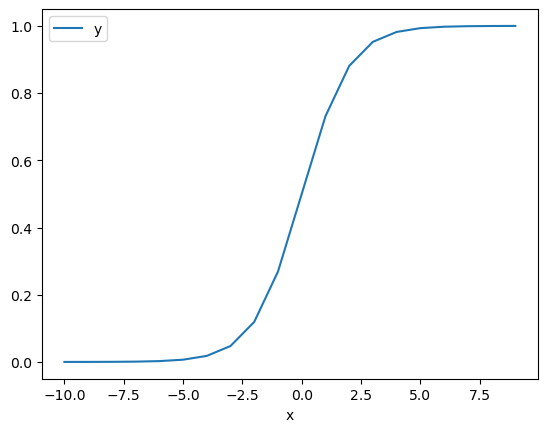

In [7]:
import pandas as pd
import math

sigmoid = lambda x: 1/(1 + math.exp(-x))

x = [i for i in range(-10, 10)]

pd.DataFrame({
    'x': x,
    'y': [sigmoid(i) for i in x]
}).plot(x='x', y='y')
